## TOC:
* [Model to predict match results](#first-bullet)
* [Model to predict # of games](#second-bullet)
* [test results](#third-bullet)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer, StandardScaler, LabelEncoder

from sklearn.impute import SimpleImputer

from sklearn_pandas import DataFrameMapper

from sklearn.metrics import accuracy_score,r2_score, roc_auc_score

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import load_model



In [44]:
data=pd.read_csv('data/final_2.csv' ,encoding = "ISO-8859-1")

In [6]:
data.head()

,uuid,Unnamed: 0,ATP,B365L,B365W,Best of,Comment,Court,Date,L1,...,one_clay_vv,one_grass_vv,one_hard_vv,one_three_vv,one_five_vv,pts_diff,player_one_pts,player_two_pts,player_one_sets,player_two_sets
0,000569ca-bcdb-4266-98a0-b409cb8932ff,383,11,5.00,1.16,3,Completed,Indoor,2016-02-09,3.0,...,0.0,0.0,1.0,1.0,0.0,301.0,414.0,113.0,2.0,0.0
1,00056f39-ba9b-4807-ac20-cbbcf9e2c304,1887,45,1.36,3.00,3,Retired,Outdoor,2010-08-04,5.0,...,NaN,NaN,NaN,NaN,NaN,-610.0,1385.0,775.0,0.0,1.0
2,000a7190-03aa-44b3-b631-e85d00f265ea,1537,39,3.00,1.36,5,Completed,Outdoor,2015-06-29,3.0,...,0.0,1.0,1.0,1.0,1.0,347.0,895.0,548.0,3.0,2.0
3,000c3ad6-ac2d-4ca8-abe9-853099f8a568,597,18,19.00,1.02,3,Completed,Outdoor,2012-02-28,3.0,...,1.0,0.0,1.0,1.0,1.0,6663.0,7150.0,487.0,2.0,1.0
4,0014c43e-cdee-41e7-a5f8-60a15a6f9cc2,2510,63,9.00,1.07,3,Completed,Indoor,2016-10-25,7.0,...,0.0,0.0,1.0,1.0,0.0,5311.0,5820.0,509.0,2.0,1.0


In [7]:
data.groupby('Comment')['Comment'].count()/len(data)

Comment
Awarded         0.000035
Completed       0.961710
Disqualified    0.000035
Retired         0.031937
Sched           0.000069
Walkover        0.006215
Name: Comment, dtype: float64

In [45]:
data=data[data.Comment=='Completed']

In [ ]:
data.columns

In [9]:
print("% of games with only top 100 players: ",len(data[(data.WRank<=100) & (data.LRank<=100)])/len(data))

% of games with only top 100 players:  0.6574639190062469


In [10]:
# % of times the higher ranked player one
data.groupby('outcome')['outcome'].count()/len(data)

outcome
0    0.335715
1    0.664285
Name: outcome, dtype: float64

In [ ]:
# % of times the higher ranked player one in 5set games
data[data['Best of']==5].groupby('outcome')['outcome'].count()/len(data[data['Best of']==5])

In [ ]:
# % of times the higher ranked player one in 5set games
data[data['Best of']==3].groupby('total_sets')['total_sets'].count()

In [ ]:
data[(data['Best of']==3) & (data.total_sets==1.0)]

In [46]:
data['rank_dif']=data['player_two_rank']-data['player_one_rank']
data['pts_dif']=data['player_two_pts']-data['player_one_pts']
data['win_rate_diff']=data['two_win_rate_year']-data['one_win_rate_year']
data['hard_diff']=data['two_hard_year']-data['one_hard_year']
data['five_diff']=data['two_five_year']-data['one_five_year']
data['three_diff']=data['two_three_year']-data['one_three_year']

data['hard_vv']=data['two_hard_vv']-data['one_hard_vv']
data['vv']=data['two_win_rate_vv']-data['one_win_rate_vv']




## Model to predict match results <a class="anchor" id="first-bullet"></a>

In [58]:
t.columns

Index(['uuid', 'Unnamed: 0', 'ATP', 'B365L', 'B365W', 'Best of', 'Comment',
       'Court', 'Date', 'L1', 'L2', 'L3', 'L4', 'L5', 'LPts', 'LRank',
       'Location', 'Loser', 'Lsets', 'Round', 'Series', 'Surface',
       'Tournament', 'W1', 'W2', 'W3', 'W4', 'W5', 'WPts', 'WRank', 'Winner',
       'Wsets', 'rank_diff', 'outcome', 'player_one', 'player_two',
       'player_one_rank', 'player_two_rank', 'uuid.1', 'one_name', 'one_date',
       'one_cutoff_date', 'one_win_rate_year', 'one_games_played_year',
       'one_clay_year', 'one_grass_year', 'one_hard_year', 'one_three_year',
       'one_five_year', 'two_name', 'two_date', 'two_cutoff_date',
       'two_win_rate_year', 'two_games_played_year', 'two_clay_year',
       'two_grass_year', 'two_hard_year', 'two_three_year', 'two_five_year',
       'major', 'total_games', 'player_one_total_games',
       'player_two_total_games', 'total_sets', 'player_two_name_vv',
       'two_cutoff_date_vv', 'two_win_rate_vv', 'two_games_played_vv',
 

In [47]:
data.shape

(27854, 95)

In [13]:
t=data


In [48]:

feature_columns=['player_one_rank','player_two_rank','Surface', 'Best of','one_win_rate_year',
       'one_games_played_year', 'one_clay_year', 'one_grass_year',
       'one_hard_year', 'one_three_year', 'one_five_year', 'two_win_rate_year',
       'two_games_played_year', 'two_clay_year', 'two_grass_year',
       'two_hard_year', 'two_three_year', 'two_five_year', 'major','one_win_rate_vv', 'one_games_played_vv', 'one_clay_vv', 'one_grass_vv',
       'one_hard_vv', 'one_three_vv', 'one_five_vv','two_win_rate_vv',
       'two_games_played_vv', 'two_clay_vv', 'two_grass_vv', 'two_hard_vv',
       'two_three_vv', 'two_five_vv', 'rank_dif', 'win_rate_diff', 'hard_diff',
       'five_diff', 'three_diff', 'hard_vv', 'vv' ,'pts_dif', 'outcome']
data=data[feature_columns].dropna()

In [49]:
target='outcome'
y=data[target]
X=data.drop('outcome',axis=1)

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [51]:
mapper = DataFrameMapper([
    (['player_one_rank'], [StandardScaler(),SimpleImputer()]),
    (['player_two_rank'], [StandardScaler(),SimpleImputer()]),
    (['Surface'], [SimpleImputer(strategy='constant', fill_value='most_frequent'),LabelBinarizer()]),
    ('Best of', LabelEncoder()),
    (['one_win_rate_year'],StandardScaler()),
    (['one_games_played_year'], StandardScaler()),
    (['one_clay_year'], StandardScaler()),
    (['one_grass_year'],StandardScaler()),
    (['one_hard_year'], StandardScaler()),
    (['one_three_year'], StandardScaler()),
    (['one_five_year'], StandardScaler()),
    (['two_win_rate_year'],StandardScaler()),
    (['two_games_played_year'], StandardScaler()),
    (['two_clay_year'], StandardScaler()),
    (['two_grass_year'],StandardScaler()),
    (['two_hard_year'], StandardScaler()),
    (['two_three_year'], StandardScaler()),
    (['two_five_year'], StandardScaler()),
    ('major', LabelEncoder()),
    (['one_win_rate_vv'],StandardScaler()), 
    (['one_games_played_vv'],StandardScaler()),  
    (['one_clay_vv'],StandardScaler()),  
    (['one_grass_vv'],StandardScaler()), 
    (['one_hard_vv'],StandardScaler()),  
    (['one_three_vv'],StandardScaler()),  
    (['one_five_vv'],StandardScaler()),
    (['two_win_rate_vv'],StandardScaler()), 
    (['two_games_played_vv'],StandardScaler()),  
    (['two_clay_vv'],StandardScaler()),  
    (['two_grass_vv'],StandardScaler()), 
    (['two_hard_vv'],StandardScaler()),  
    (['two_three_vv'],StandardScaler()),  
    (['two_five_vv'],StandardScaler()),    
    (['rank_dif'],StandardScaler()),  
    (['pts_dif'],[StandardScaler(),SimpleImputer()]),  
    (['win_rate_diff'],StandardScaler()),  
    (['hard_diff'],StandardScaler()),
    (['five_diff'],StandardScaler()), 
    (['three_diff'],StandardScaler()),
    (['hard_vv'],StandardScaler()),
    (['vv'],StandardScaler())
    
], df_out=
    True)


In [52]:
%%time
Z_train=mapper.fit_transform(X_train)
Z_test=mapper.transform(X_test)

CPU times: user 215 ms, sys: 32.5 ms, total: 248 ms
Wall time: 255 ms


In [53]:
model=LogisticRegression(C=20, max_iter=1000, n_jobs=1)

In [54]:
model.fit(Z_train,y_train)

LogisticRegression(C=20, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=1, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [55]:
model.score(Z_train,y_train)

0.6944223107569721

In [56]:
y_pred=model.predict(Z_test)

In [57]:
accuracy_score(y_test,y_pred),roc_auc_score(y_test,y_pred)

(0.7038438558056164, 0.623274026470725)

In [59]:
Z_train.columns[model.coef_.argsort()]

Index([['major', 'three_diff', 'two_hard_year', 'hard_diff', 'hard_vv', 'two_five_vv', 'two_grass_year', 'two_clay_vv', 'two_grass_vv', 'five_diff', 'two_hard_vv', 'one_clay_year', 'two_five_year', 'player_one_rank', 'two_three_vv', 'one_hard_year', 'pts_dif', 'vv', 'one_games_played_vv', 'two_games_played_vv', 'two_clay_year', 'player_two_rank', 'one_five_year', 'rank_dif', 'one_grass_year', 'one_games_played_year', 'two_games_played_year', 'one_grass_vv', 'two_three_year', 'win_rate_diff', 'one_three_vv', 'one_hard_vv', 'Surface_Hard', 'one_clay_vv', 'one_five_vv', 'Surface_Grass', 'one_win_rate_year', 'Surface_Clay', 'one_three_year', 'two_win_rate_year', 'Best of', 'two_win_rate_vv', 'one_win_rate_vv']], dtype='object')

In [60]:
m = Sequential()
m.add(Dense(units=64, activation='relu', input_shape=(Z_train.shape[1],)))
m.add(Dropout(0.2))
m.add(Dense(units=32, activation='relu'))
m.add(Dropout(0.2))
m.add(Dense(units=16, activation='relu'))
m.add(Dropout(0.2))
m.add(Dense(units=5, activation='relu'))
m.add(Dropout(0.2))
m.add(Dense(units=1, activation='sigmoid'))

m.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']) 
mc=ModelCheckpoint('data/best_model.h5', monitor='val_accuracy', mode='max', verbose=2, save_best_only=True)
early_stop = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=15)

In [61]:
hist = m.fit( Z_train,
                    y_train, 
                    batch_size=128,
                    validation_data=(Z_test, y_test),
                    epochs=175,
                    callbacks=[mc],
                    verbose=1)

Train on 20080 samples, validate on 5021 samples
Epoch 1/175
16384/20080 [=======================>......] - ETA: 0s - loss: 0.5979 - accuracy: 0.6634
Epoch 00001: val_accuracy improved from -inf to 0.69030, saving model to data/best_model.h5
20080/20080 [==============================] - 1s 48us/sample - loss: 0.5929 - accuracy: 0.6654 - val_loss: 0.5429 - val_accuracy: 0.6903
Epoch 2/175
17280/20080 [========================>.....] - ETA: 0s - loss: 0.5614 - accuracy: 0.6820
Epoch 00002: val_accuracy improved from 0.69030 to 0.70962, saving model to data/best_model.h5
20080/20080 [==============================] - 0s 19us/sample - loss: 0.5621 - accuracy: 0.6800 - val_loss: 0.5365 - val_accuracy: 0.7096
Epoch 3/175
16384/20080 [=======================>......] - ETA: 0s - loss: 0.5555 - accuracy: 0.6854
Epoch 00003: val_accuracy did not improve from 0.70962
20080/20080 [==============================] - 0s 20us/sample - loss: 0.5548 - accuracy: 0.6863 - val_loss: 0.5296 - val_accuracy:

19968/20080 [============================>.] - ETA: 0s - loss: 0.5088 - accuracy: 0.7274
Epoch 00027: val_accuracy improved from 0.73073 to 0.73173, saving model to data/best_model.h5
20080/20080 [==============================] - 0s 17us/sample - loss: 0.5088 - accuracy: 0.7276 - val_loss: 0.5083 - val_accuracy: 0.7317
Epoch 28/175
16384/20080 [=======================>......] - ETA: 0s - loss: 0.5060 - accuracy: 0.7311
Epoch 00028: val_accuracy improved from 0.73173 to 0.73432, saving model to data/best_model.h5
20080/20080 [==============================] - 0s 16us/sample - loss: 0.5074 - accuracy: 0.7286 - val_loss: 0.5060 - val_accuracy: 0.7343
Epoch 29/175
17024/20080 [========================>.....] - ETA: 0s - loss: 0.5063 - accuracy: 0.7279
Epoch 00029: val_accuracy did not improve from 0.73432
20080/20080 [==============================] - 0s 14us/sample - loss: 0.5068 - accuracy: 0.7266 - val_loss: 0.5045 - val_accuracy: 0.7343
Epoch 30/175
17408/20080 [======================

Epoch 54/175
16896/20080 [========================>.....] - ETA: 0s - loss: 0.4914 - accuracy: 0.7438
Epoch 00054: val_accuracy did not improve from 0.73969
20080/20080 [==============================] - 0s 14us/sample - loss: 0.4904 - accuracy: 0.7447 - val_loss: 0.4973 - val_accuracy: 0.7335
Epoch 55/175
17280/20080 [========================>.....] - ETA: 0s - loss: 0.4908 - accuracy: 0.7427
Epoch 00055: val_accuracy did not improve from 0.73969
20080/20080 [==============================] - 0s 14us/sample - loss: 0.4913 - accuracy: 0.7439 - val_loss: 0.4964 - val_accuracy: 0.7371
Epoch 56/175
16768/20080 [========================>.....] - ETA: 0s - loss: 0.4907 - accuracy: 0.7428
Epoch 00056: val_accuracy did not improve from 0.73969
20080/20080 [==============================] - 0s 14us/sample - loss: 0.4920 - accuracy: 0.7429 - val_loss: 0.4969 - val_accuracy: 0.7349
Epoch 57/175
16000/20080 [======================>.......] - ETA: 0s - loss: 0.4911 - accuracy: 0.7419
Epoch 00057: 

18048/20080 [=========================>....] - ETA: 0s - loss: 0.4820 - accuracy: 0.7505
Epoch 00081: val_accuracy did not improve from 0.74587
20080/20080 [==============================] - 0s 13us/sample - loss: 0.4824 - accuracy: 0.7521 - val_loss: 0.4926 - val_accuracy: 0.7397
Epoch 82/175
18304/20080 [==========================>...] - ETA: 0s - loss: 0.4795 - accuracy: 0.7513
Epoch 00082: val_accuracy did not improve from 0.74587
20080/20080 [==============================] - 0s 13us/sample - loss: 0.4806 - accuracy: 0.7511 - val_loss: 0.4926 - val_accuracy: 0.7393
Epoch 83/175
18048/20080 [=========================>....] - ETA: 0s - loss: 0.4779 - accuracy: 0.7521
Epoch 00083: val_accuracy did not improve from 0.74587
20080/20080 [==============================] - 0s 13us/sample - loss: 0.4777 - accuracy: 0.7522 - val_loss: 0.4933 - val_accuracy: 0.7439
Epoch 84/175
18048/20080 [=========================>....] - ETA: 0s - loss: 0.4796 - accuracy: 0.7479
Epoch 00084: val_accuracy 

Epoch 109/175
19584/20080 [============================>.] - ETA: 0s - loss: 0.4732 - accuracy: 0.7520
Epoch 00109: val_accuracy did not improve from 0.74587
20080/20080 [==============================] - 0s 17us/sample - loss: 0.4731 - accuracy: 0.7517 - val_loss: 0.4938 - val_accuracy: 0.7379
Epoch 110/175
16640/20080 [=======================>......] - ETA: 0s - loss: 0.4732 - accuracy: 0.7554
Epoch 00110: val_accuracy did not improve from 0.74587
20080/20080 [==============================] - 0s 14us/sample - loss: 0.4735 - accuracy: 0.7552 - val_loss: 0.4923 - val_accuracy: 0.7403
Epoch 111/175
18048/20080 [=========================>....] - ETA: 0s - loss: 0.4724 - accuracy: 0.7509
Epoch 00111: val_accuracy did not improve from 0.74587
20080/20080 [==============================] - 0s 16us/sample - loss: 0.4710 - accuracy: 0.7535 - val_loss: 0.4951 - val_accuracy: 0.7331
Epoch 112/175
19968/20080 [============================>.] - ETA: 0s - loss: 0.4717 - accuracy: 0.7533
Epoch 001

Epoch 137/175
17152/20080 [========================>.....] - ETA: 0s - loss: 0.4683 - accuracy: 0.7583
Epoch 00137: val_accuracy did not improve from 0.74587
20080/20080 [==============================] - 0s 14us/sample - loss: 0.4682 - accuracy: 0.7598 - val_loss: 0.4957 - val_accuracy: 0.7359
Epoch 138/175
18048/20080 [=========================>....] - ETA: 0s - loss: 0.4662 - accuracy: 0.7593
Epoch 00138: val_accuracy did not improve from 0.74587
20080/20080 [==============================] - 0s 13us/sample - loss: 0.4664 - accuracy: 0.7586 - val_loss: 0.4953 - val_accuracy: 0.7381
Epoch 139/175
18048/20080 [=========================>....] - ETA: 0s - loss: 0.4717 - accuracy: 0.7564
Epoch 00139: val_accuracy did not improve from 0.74587
20080/20080 [==============================] - 0s 13us/sample - loss: 0.4696 - accuracy: 0.7575 - val_loss: 0.4939 - val_accuracy: 0.7423
Epoch 140/175
18048/20080 [=========================>....] - ETA: 0s - loss: 0.4652 - accuracy: 0.7599
Epoch 001

Epoch 165/175
17920/20080 [=========================>....] - ETA: 0s - loss: 0.4630 - accuracy: 0.7634
Epoch 00165: val_accuracy did not improve from 0.74587
20080/20080 [==============================] - 0s 14us/sample - loss: 0.4619 - accuracy: 0.7629 - val_loss: 0.4964 - val_accuracy: 0.7375
Epoch 166/175
17920/20080 [=========================>....] - ETA: 0s - loss: 0.4632 - accuracy: 0.7600
Epoch 00166: val_accuracy did not improve from 0.74587
20080/20080 [==============================] - 0s 13us/sample - loss: 0.4630 - accuracy: 0.7599 - val_loss: 0.4961 - val_accuracy: 0.7359
Epoch 167/175
18304/20080 [==========================>...] - ETA: 0s - loss: 0.4630 - accuracy: 0.7619
Epoch 00167: val_accuracy did not improve from 0.74587
20080/20080 [==============================] - 0s 13us/sample - loss: 0.4623 - accuracy: 0.7617 - val_loss: 0.4999 - val_accuracy: 0.7337
Epoch 168/175
18176/20080 [==========================>...] - ETA: 0s - loss: 0.4634 - accuracy: 0.7591
Epoch 001

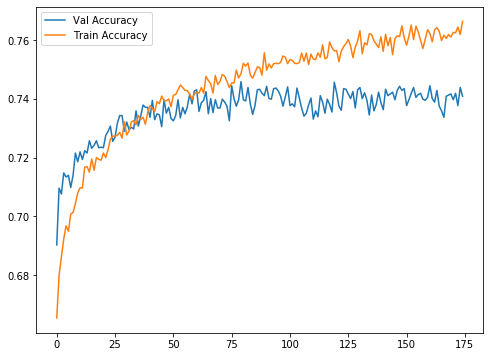

In [62]:
plt.figure(figsize=(8,6))
plt.plot(hist.history['val_accuracy'], label='Val Accuracy')
plt.plot(hist.history['accuracy'], label='Train Accuracy')
plt.legend();

## Test Results <a class="anchor" id="third-bullet"></a>

In [63]:
data=t

In [76]:
player_one_name='Cilic M.'
player_two_name='Raonic M.'
Surface='Hard'
Major=1
best_of=5
vals=[Surface,Major,best_of]
cols_to_get_one=['player_one_rank','one_win_rate_year',
       'one_games_played_year', 'one_clay_year', 'one_grass_year',
       'one_hard_year', 'one_three_year', 'one_five_year','one_hard_vv','one_win_rate_vv','one_games_played_vv'
                ,'one_three_vv','one_five_vv','player_one_pts','one_clay_vv','one_grass_vv']

cols_to_get_two=['player_two_rank','two_win_rate_year',
       'two_games_played_year', 'two_clay_year', 'two_grass_year',
       'two_hard_year', 'two_three_year', 'two_five_year','two_hard_vv','two_win_rate_vv',
                 'two_games_played_vv','two_three_vv','two_five_vv','player_two_pts','two_clay_vv',
                 'two_grass_vv']

one=list(data[data.player_one==player_one_name][cols_to_get_one].head(1).values[0])
two=list(data[data.player_two==player_two_name][cols_to_get_two].head(1).values[0])

temp=vals+one+two
temp=pd.DataFrame(temp).T
temp.columns=['Surface','major', 'Best of','player_one_rank','one_win_rate_year',
       'one_games_played_year', 'one_clay_year', 'one_grass_year',
       'one_hard_year', 'one_three_year', 'one_five_year', 'one_hard_vv','one_win_rate_vv','one_games_played_vv','one_three_vv',
              'one_five_vv','player_one_pts','one_clay_vv','one_grass_vv'
        ,'player_two_rank','two_win_rate_year',
       'two_games_played_year', 'two_clay_year', 'two_grass_year',
       'two_hard_year', 'two_three_year', 'two_five_year','two_hard_vv','two_win_rate_vv','two_games_played_vv','two_three_vv',
              'two_five_vv','player_two_pts','two_clay_vv','two_grass_vv'
             ]
# 

In [77]:
temp['pts_dif']=temp['player_two_pts']-temp['player_one_pts']
temp['rank_dif']=temp['player_two_rank']-temp['player_one_rank']
temp['win_rate_diff']=temp['two_win_rate_year']-temp['one_win_rate_year']
temp['hard_diff']=temp['two_hard_year']-temp['one_hard_year']
temp['five_diff']=temp['two_five_year']-temp['one_five_year']
temp['three_diff']=temp['two_three_year']-temp['one_three_year']

temp['hard_vv']=temp['two_hard_vv']-temp['one_hard_vv']
temp['vv']=temp['two_win_rate_vv']-temp['one_win_rate_vv']








In [78]:
temp.columns

Index(['Surface', 'major', 'Best of', 'player_one_rank', 'one_win_rate_year',
       'one_games_played_year', 'one_clay_year', 'one_grass_year',
       'one_hard_year', 'one_three_year', 'one_five_year', 'one_hard_vv',
       'one_win_rate_vv', 'one_games_played_vv', 'one_three_vv', 'one_five_vv',
       'player_one_pts', 'one_clay_vv', 'one_grass_vv', 'player_two_rank',
       'two_win_rate_year', 'two_games_played_year', 'two_clay_year',
       'two_grass_year', 'two_hard_year', 'two_three_year', 'two_five_year',
       'two_hard_vv', 'two_win_rate_vv', 'two_games_played_vv', 'two_three_vv',
       'two_five_vv', 'player_two_pts', 'two_clay_vv', 'two_grass_vv',
       'pts_dif', 'rank_dif', 'win_rate_diff', 'hard_diff', 'five_diff',
       'three_diff', 'hard_vv', 'vv'],
      dtype='object')

In [79]:
temp[['player_one_rank', 'player_two_rank']]

,player_one_rank,player_two_rank
0,3,15


In [80]:
Z_temp=mapper.transform(temp)

In [81]:
m.predict(Z_temp)

array([[0.8251812]], dtype=float32)